In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Exports/INTC_Export.csv')
print(df)

            date  1. open  2. high  3. low  4. close   5. volume
0     2000-04-10   137.50   139.10  130.90    131.10  22424500.0
1     2000-04-11   130.00   134.30  127.50    130.80  26535600.0
2     2000-04-12   129.90   131.90  121.80    121.90  30084800.0
3     2000-04-13   123.40   129.30  120.80    121.10  34707300.0
4     2000-04-14   119.20   120.80  108.40    110.50  46400200.0
...          ...      ...      ...     ...       ...         ...
5027  2020-04-03    53.85    55.13   52.73     54.13  23906062.0
5028  2020-04-06    56.63    58.77   56.12     58.43  32323387.0
5029  2020-04-07    59.94    61.49   58.21     58.40  41410012.0
5030  2020-04-08    58.99    59.51   57.91     58.98  26719500.0
5031  2020-04-09    59.36    59.72   56.06     57.14  40515419.0

[5032 rows x 6 columns]


In [2]:
df.date = pd.to_datetime(df.date)
df = df.set_index("date")

In [3]:
train = df[:-12]
test = df[-12:]
train = train.drop("1. open", axis=1)
train = train.drop("2. high", axis=1)
train = train.drop("3. low", axis=1)
test = test.drop("1. open", axis=1)
test = test.drop("2. high", axis=1)
test = test.drop("3. low", axis=1)

In [4]:
scaler = MinMaxScaler()
print(train)
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

            4. close   5. volume
date                            
2000-04-10    131.10  22424500.0
2000-04-11    130.80  26535600.0
2000-04-12    121.90  30084800.0
2000-04-13    121.10  34707300.0
2000-04-14    110.50  46400200.0
...              ...         ...
2020-03-18     47.61  49309879.0
2020-03-19     45.94  44538030.0
2020-03-20     45.83  52344045.0
2020-03-23     49.58  46698478.0
2020-03-24     52.40  50019753.0

[5020 rows x 2 columns]


In [5]:
n_input = 12
n_features = 2
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(train, train, length=n_input, batch_size=6)


In [201]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(tf.keras.layers.Reshape((2, 100)))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')


In [202]:
model.fit_generator(generator,epochs=9)


  ...
    to  
  ['...']
Train for 835 steps
Epoch 1/9
835/835 [==============================] - 13s 16ms/step - loss: 0.0032
Epoch 2/9
835/835 [==============================] - 12s 14ms/step - loss: 0.0025
Epoch 3/9
835/835 [==============================] - 12s 15ms/step - loss: 0.0022
Epoch 4/9
835/835 [==============================] - 13s 16ms/step - loss: 0.0021
Epoch 5/9
835/835 [==============================] - 12s 15ms/step - loss: 0.0021
Epoch 6/9
835/835 [==============================] - 12s 14ms/step - loss: 0.0020
Epoch 7/9
835/835 [==============================] - 12s 15ms/step - loss: 0.0021
Epoch 8/9
835/835 [==============================] - 12s 15ms/step - loss: 0.0020
Epoch 9/9
835/835 [==============================] - 12s 15ms/step - loss: 0.0020


In [227]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(np.array([model.predict(batch)[0][0][0], model.predict(batch)[0][1][0]])) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
    
    

In [241]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction', 'Prediction2'])

df_test = pd.concat([df,df_predict], axis=1)

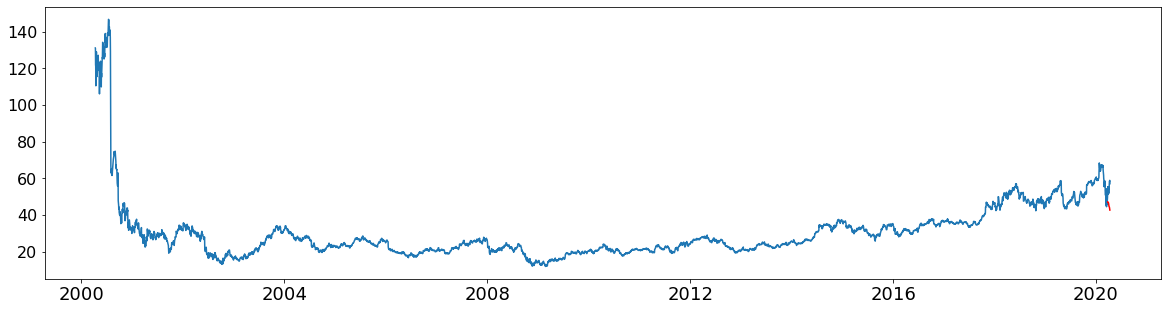

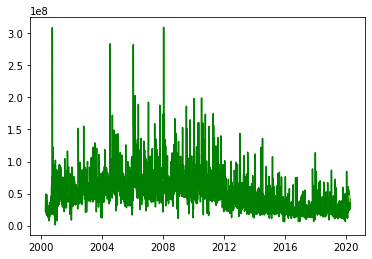

In [246]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['4. close'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()
plt.plot(df_test.index, df_test['5. volume'])
plt.plot(df_test.index, df_test['Prediction2'], color='y')
plt.show()

In [247]:
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

rmse:  [2.15324077]


In [250]:
train = df
train = train.drop("1. open", axis=1)
train = train.drop("2. high", axis=1)
train = train.drop("3. low", axis=1)

In [251]:
scaler.fit(train)
train = scaler.transform(train)

In [252]:
n_input = 12
n_features = 2
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [253]:
model.fit_generator(generator,epochs=9)

  ...
    to  
  ['...']
Train for 837 steps
Epoch 1/9
837/837 [==============================] - 12s 14ms/step - loss: 0.0019
Epoch 2/9
837/837 [==============================] - 12s 15ms/step - loss: 0.0019
Epoch 3/9
837/837 [==============================] - 13s 16ms/step - loss: 0.0020
Epoch 4/9
837/837 [==============================] - 13s 15ms/step - loss: 0.0019
Epoch 5/9
837/837 [==============================] - 12s 15ms/step - loss: 0.0019
Epoch 6/9
837/837 [==============================] - 13s 15ms/step - loss: 0.0019
Epoch 7/9
837/837 [==============================] - 12s 14ms/step - loss: 0.0019
Epoch 8/9
837/837 [==============================] - 12s 14ms/step - loss: 0.0019
Epoch 9/9
837/837 [==============================] - 12s 14ms/step - loss: 0.0018


In [254]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(np.array([model.predict(batch)[0][0][0], model.predict(batch)[0][1][0]])) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [255]:
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(days=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [256]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-12:].index, columns=['Prediction', 'Prediction2'])
df_proj = pd.concat([df,df_predict], axis=1)

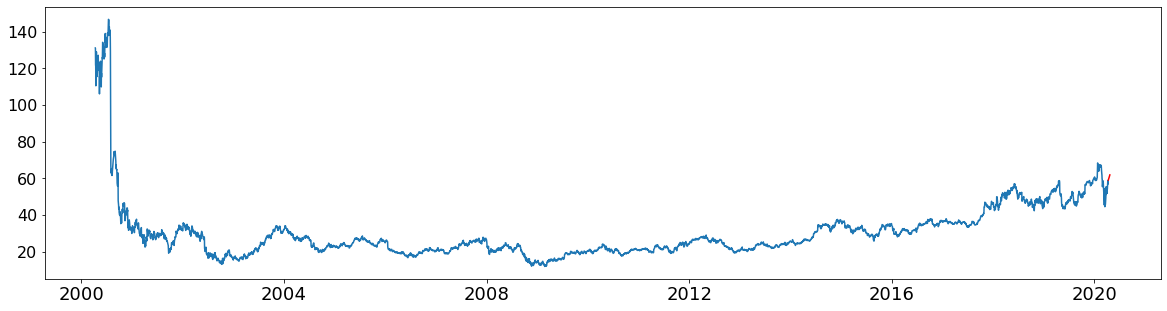

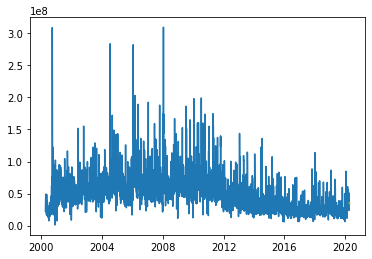

In [257]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['4. close'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()
plt.plot(df_proj.index, df_proj['5. volume'])
plt.plot(df_proj.index, df_proj['Prediction2'], color='y')
plt.show()